Yuhang Xu / Z5444602

# assignment 1


## classification task

Epoch 1/100
68/68 - 3s - loss: 8.1616 - accuracy: 0.5344 - val_loss: 7.7562 - val_accuracy: 0.5263 - 3s/epoch - 44ms/step
Epoch 2/100
68/68 - 1s - loss: 7.4791 - accuracy: 0.6180 - val_loss: 7.3128 - val_accuracy: 0.5263 - 1s/epoch - 15ms/step
Epoch 3/100
68/68 - 1s - loss: 6.8779 - accuracy: 0.6747 - val_loss: 6.7698 - val_accuracy: 0.5263 - 966ms/epoch - 14ms/step
Epoch 4/100
68/68 - 1s - loss: 6.3479 - accuracy: 0.7024 - val_loss: 6.1908 - val_accuracy: 0.5291 - 1s/epoch - 16ms/step
Epoch 5/100
68/68 - 1s - loss: 5.8110 - accuracy: 0.7449 - val_loss: 5.6372 - val_accuracy: 0.6371 - 1s/epoch - 16ms/step
Epoch 6/100
68/68 - 1s - loss: 5.3376 - accuracy: 0.7639 - val_loss: 5.1310 - val_accuracy: 0.7479 - 1s/epoch - 15ms/step
Epoch 7/100
68/68 - 1s - loss: 4.9058 - accuracy: 0.7802 - val_loss: 4.6734 - val_accuracy: 0.8144 - 1s/epoch - 15ms/step
Epoch 8/100
68/68 - 1s - loss: 4.4962 - accuracy: 0.7941 - val_loss: 4.2657 - val_accuracy: 0.8384 - 1s/epoch - 16ms/step
Epoch 9/100
68/68 - 1

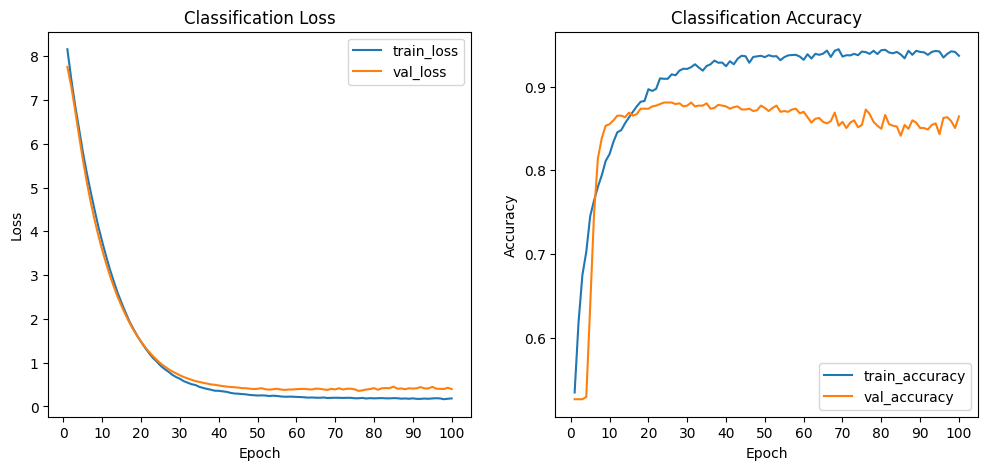

43/43 [==============================] - 0s 2ms/step

Table 2: Confusion matrix for the test data for the classification task.
Confusion Matrix:
                 |  Positive (Actual)  |  Negative (Actual)
 Positive (Predicted) |       838          |       50
 Negative (Predicted) |       79          |       385

Table 3: Accuracy and precision for the test data for the classification task.
Accuracy: 0.90
Precision: 0.89
Number of Samples: 1352


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score


def process_and_train(file_path):
    # Read data
    data = pd.read_excel(file_path)

    # Replace invalid data values with NaN
    data.replace(-200, np.nan, inplace=True)

    # Create classification task labels based on the mean CO(GT) value
    CO_mean = data['CO(GT)'].mean()
    data['CO_Class'] = data['CO(GT)'].apply(lambda x: 1 if x > CO_mean else 0)

    # Drop rows where the target variable is nan
    data.dropna(subset=['CO(GT)'], inplace=True)

    # Exclude date, time, and target variable columns; select the remaining features
    exclude_columns = ['Date', 'Time', 'CO_Class', 'CO(GT)']
    features = [col for col in data.columns if col not in exclude_columns]
    X = data[features]
    y = data['CO_Class']

   # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # Fill missing values in the training set with the mean of each feature
    train_mean = X_train.mean()
    X_train.fillna(train_mean, inplace=True)
    X_test.fillna(train_mean, inplace=True)

    # Add lag features to the dataset
    def add_lag_features(df, lags=3):
        for lag in range(1, lags + 1):
            for feature in features:
                df[f'{feature}_lag{lag}'] = df[feature].shift(lag)
        return df

    X_train = add_lag_features(X_train)
    X_test = add_lag_features(X_test)

    # Drop rows with missing values after adding lag features
    X_train.dropna(inplace=True)
    X_test.dropna(inplace=True)

    # Update labels to match the features after dropping rows
    y_train = y_train.loc[X_train.index]
    y_test = y_test.loc[X_test.index]

    # Standardize the data (zero mean, unit variance)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the data to fit the input shape of a CNN
    X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
    X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

    # Define a CNN with L2 regularization
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.1), input_shape=(X_train_scaled.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model without detailed output
    history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=64, verbose=2)

    # Save the model
    # model.save('classification_model.h5')
    
    # Save the scaler object
    # joblib.dump(scaler, 'scaler_classification.pkl')
    # joblib.dump(features, 'features_classification.pkl')

    # Plot loss and accuracy curves
    epochs = len(history.history['loss'])
    epoch_range = np.arange(1, epochs + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, history.history['loss'], label='train_loss')
    plt.plot(epoch_range, history.history['val_loss'], label='val_loss')
    plt.xticks(np.linspace(0, 100, num=11, endpoint=True))
    plt.legend()
    plt.title('Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, history.history['accuracy'], label='train_accuracy')
    plt.plot(epoch_range, history.history['val_accuracy'], label='val_accuracy')
    plt.xticks(np.linspace(0, 100, num=11, endpoint=True))
    plt.legend()
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.show()

    # Predict the test set
    y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute accuracy and precision
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # Table 2: Confusion Matrix
    print("\nTable 2: Confusion matrix for the test data for the classification task.")
    print(f"Confusion Matrix:")
    print(f"                 |  Positive (Actual)  |  Negative (Actual)")
    print(f" Positive (Predicted) |       {cm[0, 0]}          |       {cm[0, 1]}")
    print(f" Negative (Predicted) |       {cm[1, 0]}          |       {cm[1, 1]}")

    # Table 3: Accuracy and Precision
    num_samples = len(y_test)
    print("\nTable 3: Accuracy and precision for the test data for the classification task.")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Number of Samples: {num_samples}")

process_and_train(r"AirQualityUCI _ Students.xlsx")


### classification script

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

def simulate_and_test(file_path):
    # Load the model
    model = load_model('classification_model.h5')
    
    # Load the scaler object
    scaler = joblib.load('scaler_classification.pkl')
    features = joblib.load('features_classification.pkl')

    # Read data
    data = pd.read_excel(file_path)

    # Data cleaning
    data.replace(-200, np.nan, inplace=True)

    # Create classification task labels
    CO_mean = data['CO(GT)'].mean()
    data['CO_Class'] = data['CO(GT)'].apply(lambda x: 1 if x > CO_mean else 0)

    # Drop rows where the target variable is nan
    data.dropna(subset=['CO(GT)'], inplace=True)

    # Select the remaining features
    X = data[features].copy()
    y = data['CO_Class'].copy()

    # Fill missing values with the mean of the training set
    train_mean = X.mean()
    X.loc[:, :] = X.fillna(train_mean)

    # Add lag features
    def add_lag_features(df, lags=3):
        for lag in range(1, lags + 1):
            for feature in features:
                df.loc[:, f'{feature}_lag{lag}'] = df.loc[:, feature].shift(lag)
        return df

    X = add_lag_features(X)

    # Drop rows with missing values after adding lag features
    X.dropna(inplace=True)

    # Update labels to match the features after dropping rows
    y = y.loc[X.index]

    # Standardize the data
    X_scaled = scaler.transform(X)

    # Reshape the data to fit the input shape of a CNN
    X_scaled = np.expand_dims(X_scaled, axis=2)

    # Predict the test set
    y_pred = (model.predict(X_scaled) > 0.5).astype("int32")

    # Compute confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Compute accuracy and precision
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)

    # Table 2: Confusion Matrix
    print("\nTable 2: Confusion matrix for the test data for the classification task.")
    print(f"Confusion Matrix:")
    print(f"                 |  Positive (Actual)  |  Negative (Actual)")
    print(f" Positive (Predicted) |       {cm[0, 0]}          |       {cm[0, 1]}")
    print(f" Negative (Predicted) |       {cm[1, 0]}          |       {cm[1, 1]}")

    # Table 3: Accuracy and Precision
    num_samples = len(y)
    print("\nTable 3: Accuracy and precision for the test data for the classification task.")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Number of Samples: {num_samples}")

simulate_and_test(r"Generalization Dataset.xlsx")


28/28 [==============================] - 0s 3ms/step

Table 2: Confusion matrix for the test data for the classification task.
Confusion Matrix:
                 |  Positive (Actual)  |  Negative (Actual)
 Positive (Predicted) |       503          |       24
 Negative (Predicted) |       26          |       316

Table 3: Accuracy and precision for the test data for the classification task.
Accuracy: 0.94
Precision: 0.93
Number of Samples: 869


## regression task

Epoch 1/100
136/136 - 1s - loss: 60617.4844 - val_loss: 13435.7158 - 1s/epoch - 8ms/step
Epoch 2/100
136/136 - 0s - loss: 12600.3457 - val_loss: 10375.3652 - 262ms/epoch - 2ms/step
Epoch 3/100
136/136 - 0s - loss: 10164.1982 - val_loss: 8274.2900 - 171ms/epoch - 1ms/step
Epoch 4/100
136/136 - 0s - loss: 9356.5107 - val_loss: 7544.0317 - 288ms/epoch - 2ms/step
Epoch 5/100
136/136 - 0s - loss: 8520.5488 - val_loss: 6911.9907 - 325ms/epoch - 2ms/step
Epoch 6/100
136/136 - 0s - loss: 8014.9834 - val_loss: 6601.5181 - 287ms/epoch - 2ms/step
Epoch 7/100
136/136 - 0s - loss: 7975.3135 - val_loss: 6292.6870 - 329ms/epoch - 2ms/step
Epoch 8/100
136/136 - 0s - loss: 7508.5542 - val_loss: 6196.4536 - 276ms/epoch - 2ms/step
Epoch 9/100
136/136 - 0s - loss: 7152.9980 - val_loss: 5997.8628 - 263ms/epoch - 2ms/step
Epoch 10/100
136/136 - 0s - loss: 7500.4839 - val_loss: 5905.4126 - 264ms/epoch - 2ms/step
Epoch 11/100
136/136 - 0s - loss: 7434.9712 - val_loss: 6057.0942 - 262ms/epoch - 2ms/step
Epoch 

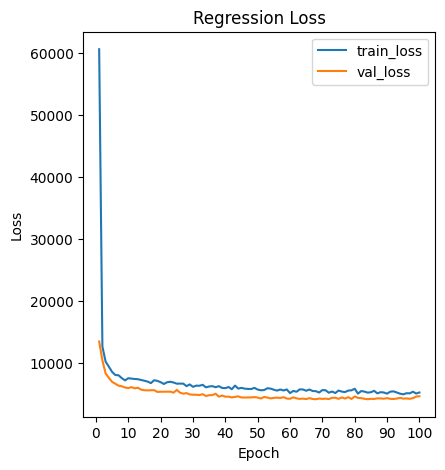

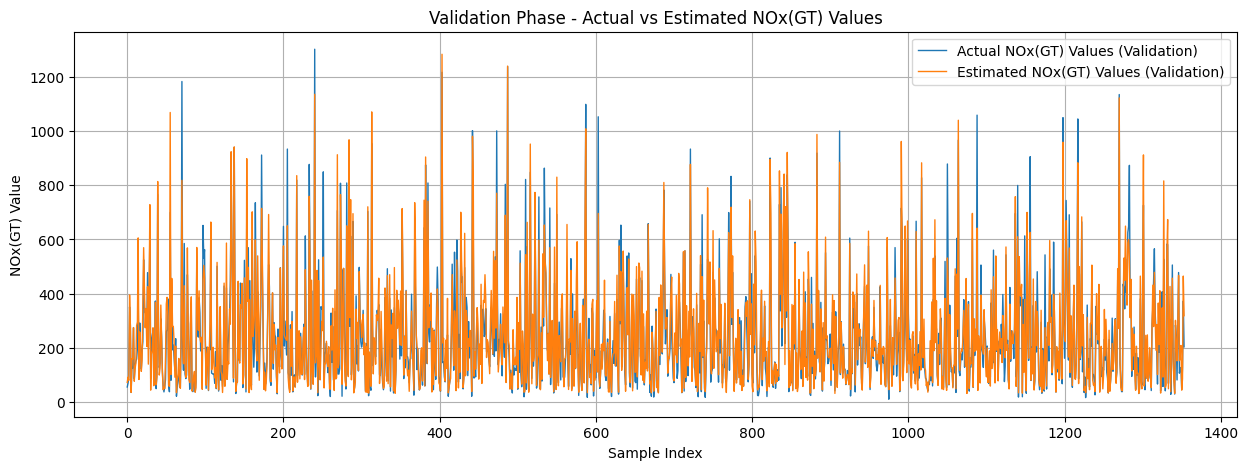

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def process_and_train(file_path):
    # Read data
    data = pd.read_excel(file_path)

    # Data cleaning: replace invalid values (-200) with NaN and drop rows where the target variable (NOx(GT)) is NaN
    data.replace(-200, np.nan, inplace=True)
    data.dropna(subset=['NOx(GT)'], inplace=True)

    # Exclude date, time, and target variable columns; select the remaining features
    exclude_columns = ['Date', 'Time', 'NOx(GT)']
    features = [col for col in data.columns if col not in exclude_columns]
    X = data[features]
    y = data['NOx(GT)']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fill missing values in the training set with the mean of each feature
    train_mean = X_train.mean()
    X_train.fillna(train_mean, inplace=True)
    X_test.fillna(train_mean, inplace=True)

    # Add lag features
    def add_lag_features(df, lags=3):
        for lag in range(1, lags + 1):
            for feature in features:
                df[f'{feature}_lag{lag}'] = df[feature].shift(lag)
        return df

    X_train = add_lag_features(X_train)
    X_test = add_lag_features(X_test)

    # Drop rows with missing values after adding lag features
    X_train.dropna(inplace=True)
    X_test.dropna(inplace=True)

    # Update labels to match the features after dropping rows
    y_train = y_train.loc[X_train.index]
    y_test = y_test.loc[X_test.index]

    # Standardize the data (zero mean, unit variance)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define a neural network with L2 regularization
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='linear'))

    # Compile the model with Adam optimizer and mean squared error loss
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    # Train the model without detailed output
    batch_size = 32
    epochs = 100
    history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=2)

    # # Save the model
    # model.save('regression_model.h5')
    
    # # Save the scaler object
    # joblib.dump(scaler, 'scaler_regression.pkl')
    
    # # Save the features object
    # joblib.dump(features, 'features_regression.pkl')

    # Predict the test set
    y_pred = model.predict(X_test_scaled)

    # Compute RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Print the number of samples
    num_samples = len(y_test)
    
    # Print the result table
    print("Table 4: Result table for the test data for the regression task.")
    print("---------------------------------------------------")
    print("|   RMSE   |   MAE   | Number of Samples |")
    print("---------------------------------------------------")
    print("|  {:.2f}  |  {:.2f}  |        {}        |".format(rmse, mae, num_samples))
    print("---------------------------------------------------")


    # Plot loss and prediction results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, epochs + 1), history.history['loss'], label='train_loss')
    plt.plot(np.arange(1, epochs + 1), history.history['val_loss'], label='val_loss')
    plt.xticks(np.linspace(0, epochs, num=11, endpoint=True))
    plt.legend()
    plt.title('Regression Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot actual vs predicted NOx(GT) values
    num_samples_to_display = 2000  # Number of samples to display, can be adjusted for best effect

    plt.figure(figsize=(15, 5))
    plt.plot(y_test[:num_samples_to_display].reset_index(drop=True), label='Actual NOx(GT) Values (Validation)', linewidth=1)
    plt.plot(y_pred[:num_samples_to_display], label='Estimated NOx(GT) Values (Validation)', linewidth=1)
    plt.xlabel('Sample Index')
    plt.ylabel('NOx(GT) Value')
    plt.title('Validation Phase - Actual vs Estimated NOx(GT) Values')
    plt.legend()
    plt.grid(True)
    plt.show()

process_and_train(r"AirQualityUCI _ Students.xlsx")


## regression script

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

def preprocess_unseen_data(unseen_data, scaler, features, lags=3):
    # Replace -200 with NaN
    unseen_data.replace(-200, np.nan, inplace=True)

    # Fill missing values with the training data mean
    numeric_data = unseen_data.select_dtypes(include=[np.number])  # Select only numeric columns
    train_mean = numeric_data.mean()
    unseen_data.fillna(train_mean, inplace=True)

    # Add lag features
    def add_lag_features(df, lags=3):
        for lag in range(1, lags + 1):
            for feature in features:
                df.loc[:, f'{feature}_lag{lag}'] = df.loc[:, feature].shift(lag)
        return df

    unseen_data = add_lag_features(unseen_data)

    # Drop rows with missing values after adding lag features
    unseen_data.dropna(inplace=True)

    # Standardize the data
    X_unseen_scaled = scaler.transform(unseen_data)

    return X_unseen_scaled

def simulate_and_test(file_path):
    # Load the model
    model = load_model('regression_model.h5')
    
    # Load the scaler object
    scaler = joblib.load('scaler_regression.pkl')
    features = joblib.load('features_regression.pkl')

    # Read data
    data = pd.read_excel(file_path)

    # Data cleaning
    data.replace(-200, np.nan, inplace=True)

    # Drop rows where the target variable is nan
    data.dropna(subset=['NOx(GT)'], inplace=True)

    # Select the remaining features
    X = data[features].copy()
    y = data['NOx(GT)'].copy()

    # Fill missing values with the mean of the training set
    train_mean = X.mean()
    X.loc[:, :] = X.fillna(train_mean)

    # Add lag features
    def add_lag_features(df, lags=3):
        for lag in range(1, lags + 1):
            for feature in features:
                df.loc[:, f'{feature}_lag{lag}'] = df.loc[:, feature].shift(lag)
        return df

    X = add_lag_features(X)

    # Drop rows with missing values after adding lag features
    X.dropna(inplace=True)

    # Update labels to match the features after dropping rows
    y = y.loc[X.index]

    # Standardize the data
    X_scaled = scaler.transform(X)

    # Predict the test set
    y_pred = model.predict(X_scaled)

    # Compute RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)

    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

simulate_and_test(r"Generalization Dataset.xlsx")


28/28 [==============================] - 0s 1ms/step
RMSE: 65.69
MAE: 44.14
